Begin comprehensive analysis of PH3 data...
Successful loading PH3_v=1: 10000 行, 16 列
Successful loading PH3_v=10: 1001 行, 16 列
Successful loading PH3_v=20: 501 行, 16 列

=== PH3 Comparison of basic data information ===
data set  data point  Temperature points Wave number range temperature range          Data range
 PH3_v=1       10000                  15          0 - 9999  t=100k - t=1500k 7.45e-41 - 1.29e-18
PH3_v=10        1001                  15         0 - 10000  t=100k - t=1500k 1.36e-39 - 4.43e-19
PH3_v=20         501                  15         0 - 10000  t=100k - t=1500k 1.68e-39 - 3.86e-19

=== Starting Machine Learning Analytics ===

分析 PH3_v=1...
PH3_v=1 Model evaluation completed
  R² = 0.4946
  RMSE = 1.0029e+00
  MAPE = 264.79%

分析 PH3_v=10...
PH3_v=10 Model evaluation completed
  R² = -0.0082
  RMSE = 1.4993e+00
  MAPE = 281.32%

分析 PH3_v=20...
PH3_v=20 Model evaluation completed
  R² = -0.0218
  RMSE = 1.6321e+00
  MAPE = 370.19%


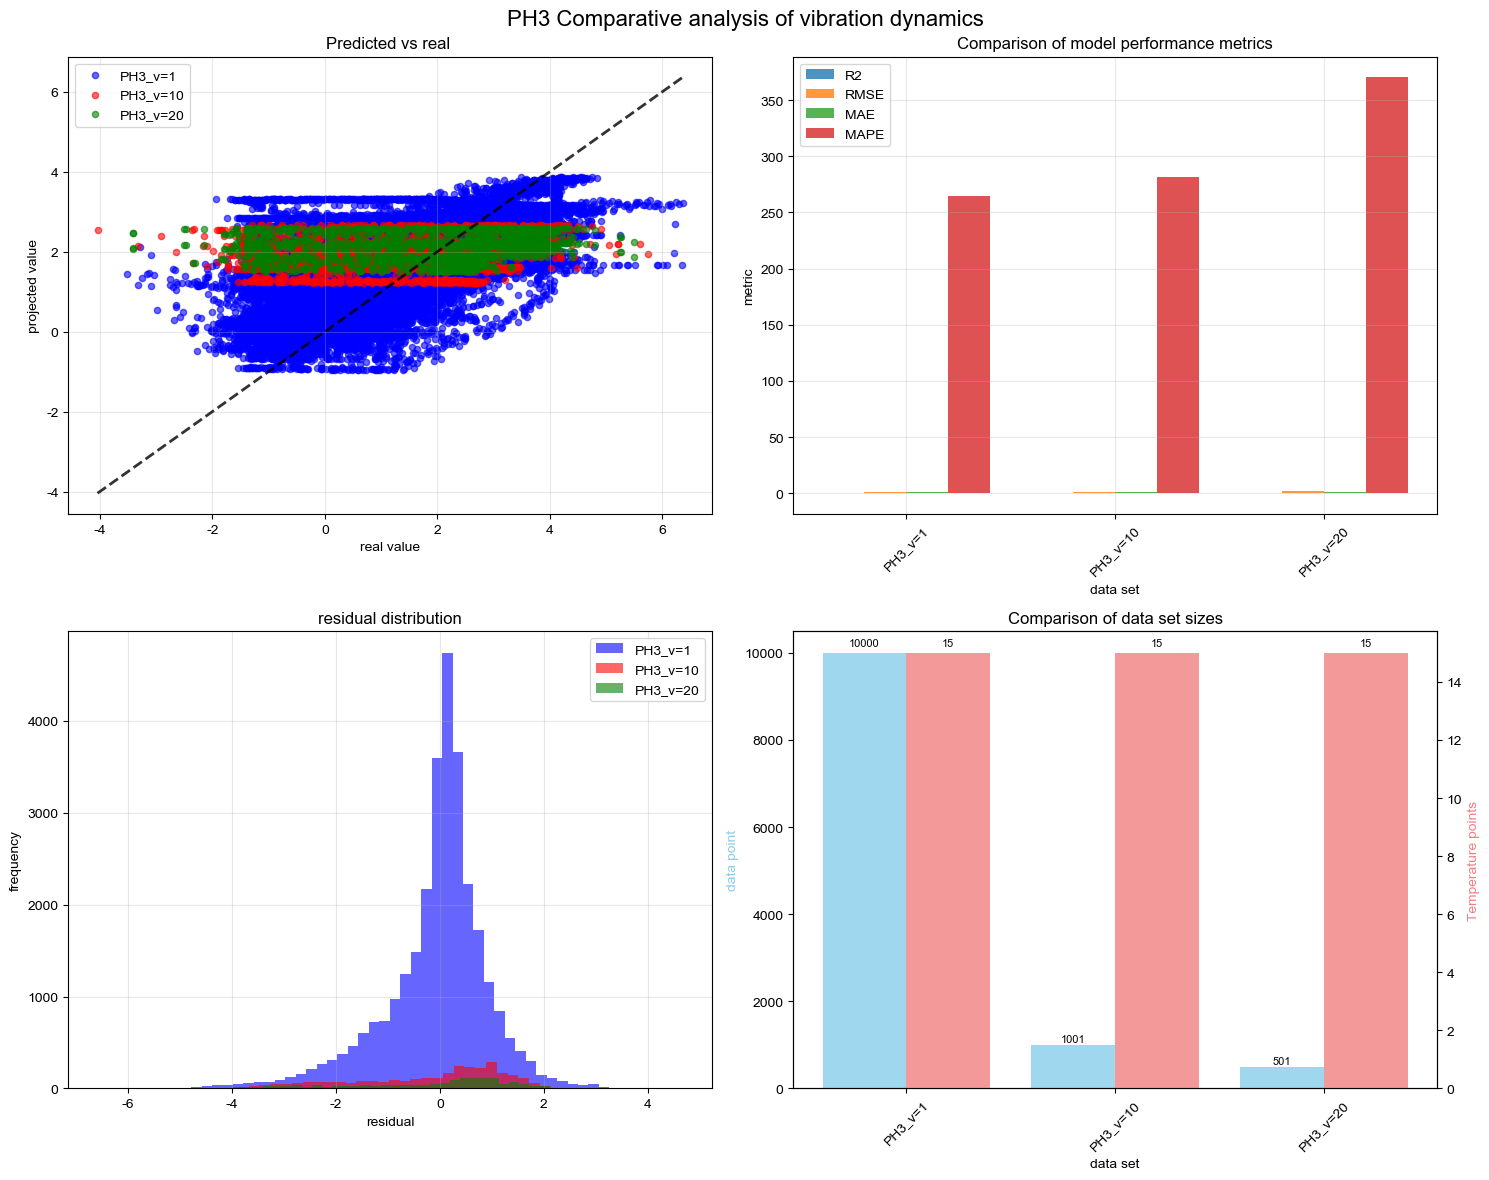


PH3 Summary report on the analysis of vibration dynamics data

1. Overview of data sets:
   PH3_v=1: 10000data point, 15temperature point
   PH3_v=10: 1001data point, 15temperature point
   PH3_v=20: 501data point, 15temperature point

2. Model Performance Comparison:
data set      R²       RMSE        MAE MAPE(%)        GME
 PH3_v=1  0.4946 1.0029e+00 6.9703e-01  264.79 3.8235e-01
PH3_v=10 -0.0082 1.4993e+00 1.1907e+00  281.32 8.1692e-01
PH3_v=20 -0.0218 1.6321e+00 1.2811e+00  370.19 8.7483e-01

3. best performance:
   best R²: PH3_v=1 (R² = 0.4946)
   lowestRMSE: PH3_v=1 (RMSE = 1.0029e+00)

=== PH3 Comparison of basic data information ===
data set  data point  Temperature points Wave number range temperature range          Data range
 PH3_v=1       10000                  15          0 - 9999  t=100k - t=1500k 7.45e-41 - 1.29e-18
PH3_v=10        1001                  15         0 - 10000  t=100k - t=1500k 1.36e-39 - 4.43e-19
PH3_v=20         501                  15         0 - 10000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gmean
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
def make_poly_mlp(model, degree=2):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        model
    )

class PH3DataAnalyzer:
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.datasets = {}
        self.results = {}
        
    def load_data(self):
         """Load all PH3 data files"""
         for file_path in self.file_paths:
        # Extracting vibrational information from filenames - using more precise matching
            if file_path.endswith('ph3_v=1.xlsm'):
                key = 'PH3_v=1'
            elif file_path.endswith('ph3_v=10.xlsm'):
                key = 'PH3_v=10'
            elif file_path.endswith('ph3_v=20.xlsm'):
                key = 'PH3_v=20'
            else:
                key = file_path.split('/')[-1].replace('.xlsm', '')
        
            try:
                df = pd.read_excel(file_path)
                self.datasets[key] = df
                print(f"Successful loading {key}: {df.shape[0]} 行, {df.shape[1]} 列")
            except Exception as e:
                print(f"load {file_path} go wrong: {e}")
    def basic_info_comparison(self):
        """Comparison of basic information"""
        print("\n=== PH3 Comparison of basic data information ===")
        info_data = []
        
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            info_data.append({
                'data set': name,
                'data point': len(df),
                'Temperature points': len(temp_cols),
                'Wave number range': f"{df['wavenumber'].min():.0f} - {df['wavenumber'].max():.0f}",
                'temperature range': f"{temp_cols[0]} - {temp_cols[-1]}",
                'Data range': f"{df[temp_cols].min().min():.2e} - {df[temp_cols].max().max():.2e}"
            })
        
        info_df = pd.DataFrame(info_data)
        print(info_df.to_string(index=False))
        return info_df
    
    def preprocess_data(self, df, test_temps=['t=1300k', 't=1400k', 't=1500k']):
        """Data pre-processing and standardisation"""
        # Get available test temperature columns
        available_test_temps = [col for col in test_temps if col in df.columns]
        if not available_test_temps:
            # If no test temperature is specified, use the last few temperature points
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            available_test_temps = temp_cols[-3:] if len(temp_cols) >= 3 else temp_cols[-1:]
        
        # Training data columns
        train_cols = [col for col in df.columns if col.startswith('t=') and col not in available_test_temps]
        
        if not train_cols:
            print(f"Warning: not enough training data columns")
            return None, None, None, None
        
        # Extracting training data
        train_data = df[train_cols].copy()
        
        # standardisation by bank
        row_means = train_data.mean(axis=1)
        row_stds = train_data.std(axis=1)
        
        # Avoid dividing by zero
        row_stds = row_stds.replace(0, 1e-10)
        
        # Standardised training data
        train_scaled = (train_data.subtract(row_means, axis=0)).divide(row_stds, axis=0)
        
        # Standardised test data
        if available_test_temps:
            test_data = df[available_test_temps].copy()
            test_scaled = (test_data.subtract(row_means, axis=0)).divide(row_stds, axis=0)
        else:
            test_scaled = pd.DataFrame()
        
        #Creating the final training and test data frame
        train_df = pd.concat([df[['wavenumber']], train_scaled], axis=1)
        test_df = pd.concat([df[['wavenumber']], test_scaled], axis=1) if not test_scaled.empty else pd.DataFrame()
        
        return train_df, test_df, row_means, row_stds
    
    def prepare_ml_data(self, train_df, test_df):
        """Preparing Machine Learning Data"""
        if train_df is None or train_df.empty:
            return None, None, None, None
        
        # Convert to long format
        train_long = pd.melt(
            train_df,
            id_vars='wavenumber',
            value_vars=[col for col in train_df.columns if col.startswith('t=')],
            var_name='temperature',
            value_name='cross_section'
        )
        
        # Clear temperature columns
        train_long['temperature'] = train_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)
        
        X_train = train_long[['wavenumber', 'temperature']]
        y_train = train_long['cross_section']
        
        # Processing of test data
        if test_df is not None and not test_df.empty:
            test_long = pd.melt(
                test_df,
                id_vars='wavenumber',
                value_vars=[col for col in test_df.columns if col.startswith('t=')],
                var_name='temperature',
                value_name='cross_section'
            )
            
            test_long['temperature'] = test_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)
            
            X_test = test_long[['wavenumber', 'temperature']]
            y_test = test_long['cross_section']
        else:
            X_test, y_test = None, None
        
        return X_train, y_train, X_test, y_test
    
    def train_model(self, X_train, y_train, degree=6, alpha=1.0):
        """Training polynomial regression models"""
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=6)
        
        model.fit(X_train, y_train)
        return model
    
    def evaluate_model(self, model, X_test, y_test):
        """Evaluating model performance"""
        if X_test is None or y_test is None:
            return None
        
        y_pred = model.predict(X_test)
        
        # Calculation of assessment indicators
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calculate MAPE to avoid dividing by zero
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        # Calculation of geometric mean error
        gme = gmean(np.abs(y_test - y_pred) + 1e-8)
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape,
            'GME': gme,
            'y_test': y_test,
            'y_pred': y_pred
        }
    
    def analyze_all_datasets(self):
        """Analysing all data sets"""
        print("\n=== Starting Machine Learning Analytics ===")
        
        for name, df in self.datasets.items():
            print(f"\n分析 {name}...")
            
            # Data preprocessing
            train_df, test_df, row_means, row_stds = self.preprocess_data(df)
            
            if train_df is None:
                print(f"skip over {name}: Data preprocessing failure")
                continue
            
            # Preparing Machine Learning Data
            X_train, y_train, X_test, y_test = self.prepare_ml_data(train_df, test_df)
            
            if X_train is None:
                print(f"skip over {name}: Machine Learning Data Preparation Failure")
                continue
            
            # Training Models
            model = make_poly_mlp(
                    MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000, random_state=1),
                    degree=2
                )
            model.fit(X_train, y_train)

            # assessment model
            if X_test is not None:
                evaluation = self.evaluate_model(model, X_test, y_test)
                if evaluation:
                    self.results[name] = evaluation
                    print(f"{name} Model evaluation completed")
                    print(f"  R² = {evaluation['R2']:.4f}")
                    print(f"  RMSE = {evaluation['RMSE']:.4e}")
                    print(f"  MAPE = {evaluation['MAPE']:.2f}%")
            else:
                print(f"{name}: No test data, skip evaluation")
    
    def plot_comparison_results(self):
        """Plotting Comparison Results"""
        if not self.results:
            print("No results available for mapping")
            return
        
        # Creating Graphics
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('PH3 Comparative analysis of vibration dynamics', fontsize=16, fontweight='bold')
        
        # 1. Scatterplot of predicted vs. true values
        ax1 = axes[0, 0]
        colors = ['blue', 'red', 'green']
        for i, (name, result) in enumerate(self.results.items()):
            y_test = result['y_test']
            y_pred = result['y_pred']
            ax1.scatter(y_test, y_pred, alpha=0.6, s=20, color=colors[i % len(colors)], label=name)
        
        # Add y=x line
        all_y = np.concatenate([result['y_test'] for result in self.results.values()])
        min_val, max_val = all_y.min(), all_y.max()
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)
        ax1.set_xlabel('real value')
        ax1.set_ylabel('projected value')
        ax1.set_title('Predicted vs real ')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Comparison of model performance metrics
        ax2 = axes[0, 1]
        metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
        x_pos = np.arange(len(self.results))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            values = [self.results[name][metric] for name in self.results.keys()]
            ax2.bar(x_pos + i * width, values, width, label=metric, alpha=0.8)
        
        ax2.set_xlabel('data set')
        ax2.set_ylabel('metric')
        ax2.set_title('Comparison of model performance metrics')
        ax2.set_xticks(x_pos + width * 1.5)
        ax2.set_xticklabels(list(self.results.keys()), rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. residual distribution
        ax3 = axes[1, 0]
        for i, (name, result) in enumerate(self.results.items()):
            residuals = result['y_test'] - result['y_pred']
            ax3.hist(residuals, bins=50, alpha=0.6, label=name, color=colors[i % len(colors)])
        
        ax3.set_xlabel('residual')
        ax3.set_ylabel('frequency')
        ax3.set_title('residual distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4.Comparison of basic information of data sets
        ax4 = axes[1, 1]
        info_data = []
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            info_data.append([name, len(df), len(temp_cols)])
        
        info_array = np.array(info_data)
        x_pos = np.arange(len(info_data))
        
        ax4_twin = ax4.twinx()
        bars1 = ax4.bar(x_pos - 0.2, [int(x) for x in info_array[:, 1]], 0.4, label='数据点数', alpha=0.8, color='skyblue')
        bars2 = ax4_twin.bar(x_pos + 0.2, [int(x) for x in info_array[:, 2]], 0.4, label='温度点数', alpha=0.8, color='lightcoral')
        
        ax4.set_xlabel('data set')
        ax4.set_ylabel('data point', color='skyblue')
        ax4_twin.set_ylabel('Temperature points', color='lightcoral')
        ax4.set_title('Comparison of data set sizes')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([x[0] for x in info_data], rotation=45)
        
        # Adding numeric labels
        for bar in bars1:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{int(height)}', 
                    ha='center', va='bottom', fontsize=8)
        
        for bar in bars2:
            height = bar.get_height()
            ax4_twin.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{int(height)}', 
                         ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.savefig('ph3_comparison_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_summary_report(self):
        """Generate summary reports"""
        print("\n" + "="*60)
        print("PH3 Summary report on the analysis of vibration dynamics data")
        print("="*60)
        
        # Basic information
        print("\n1. Overview of data sets:")
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            print(f"   {name}: {len(df)}data point, {len(temp_cols)}temperature point")
        
        # Model performance
        if self.results:
            print("\n2. Model Performance Comparison:")
            performance_data = []
            for name, result in self.results.items():
                performance_data.append({
                    'data set': name,
                    'R²': f"{result['R2']:.4f}",
                    'RMSE': f"{result['RMSE']:.4e}",
                    'MAE': f"{result['MAE']:.4e}",
                    'MAPE(%)': f"{result['MAPE']:.2f}",
                    'GME': f"{result['GME']:.4e}"
                })
            
            performance_df = pd.DataFrame(performance_data)
            print(performance_df.to_string(index=False))
            
            # Finding the best model
            best_r2 = max(self.results.items(), key=lambda x: x[1]['R2'])
            best_rmse = min(self.results.items(), key=lambda x: x[1]['RMSE'])
            
            print(f"\n3. best performance:")
            print(f"   best R²: {best_r2[0]} (R² = {best_r2[1]['R2']:.4f})")
            print(f"   lowestRMSE: {best_rmse[0]} (RMSE = {best_rmse[1]['RMSE']:.4e})")
        
        # Save results to Excel
        if self.results:
            with pd.ExcelWriter('ph3_analysis_results.xlsx', engine='openpyxl') as writer:
                # Basic information
                info_df = self.basic_info_comparison()
                info_df.to_excel(writer, sheet_name='Basic information', index=False)
                
                # Performance indicators
                performance_df.to_excel(writer, sheet_name='Performance indicators', index=False)
                
                print(f"\nThe results have been saved to ph3_analysis_results.xlsx")
    
    def run_complete_analysis(self):
        """Run a complete analysis"""
        print("Begin comprehensive analysis of PH3 data...")
        
        # Load data
        self.load_data()
        
        if not self.datasets:
            print("No dataset was successfully loaded")
            return
        
        # Comparison of basic information
        self.basic_info_comparison()
        
        # Machine Learning Analytics
        self.analyze_all_datasets()
        
        # Plotting comparisons
        self.plot_comparison_results()
        
        # Generate summary reports
        self.generate_summary_report()
        
        print("\nPH3 data analysis completed！")

# 主程序
if __name__ == "__main__":
    #PH3 Data File Path
    ph3_files = [
        '/Users/shuaiyuanzhen/Desktop/High temperature extrapolation/ph3_v=1.xlsm',
        '/Users/shuaiyuanzhen/Desktop/High temperature extrapolation/ph3_v=10.xlsm',
        '/Users/shuaiyuanzhen/Desktop/High temperature extrapolation/ph3_v=20.xlsm'
    ]
    
    #Create an analyser and run the analysis
    analyzer = PH3DataAnalyzer(ph3_files)
    analyzer.run_complete_analysis()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e+04, tolerance: 1.100e+01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+03, tolerance: 1.101e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e+03, toler

    Dataset       MSE      RMSE       MAE            R2
0   ph3 v=1  4.124825  2.030966  1.993178 -3.535470e+40
1  ph3 v=10  4.065664  2.016349  1.975894 -3.570716e+40
2  ph3 v=20  4.048491  2.012086  1.965370 -3.723570e+40


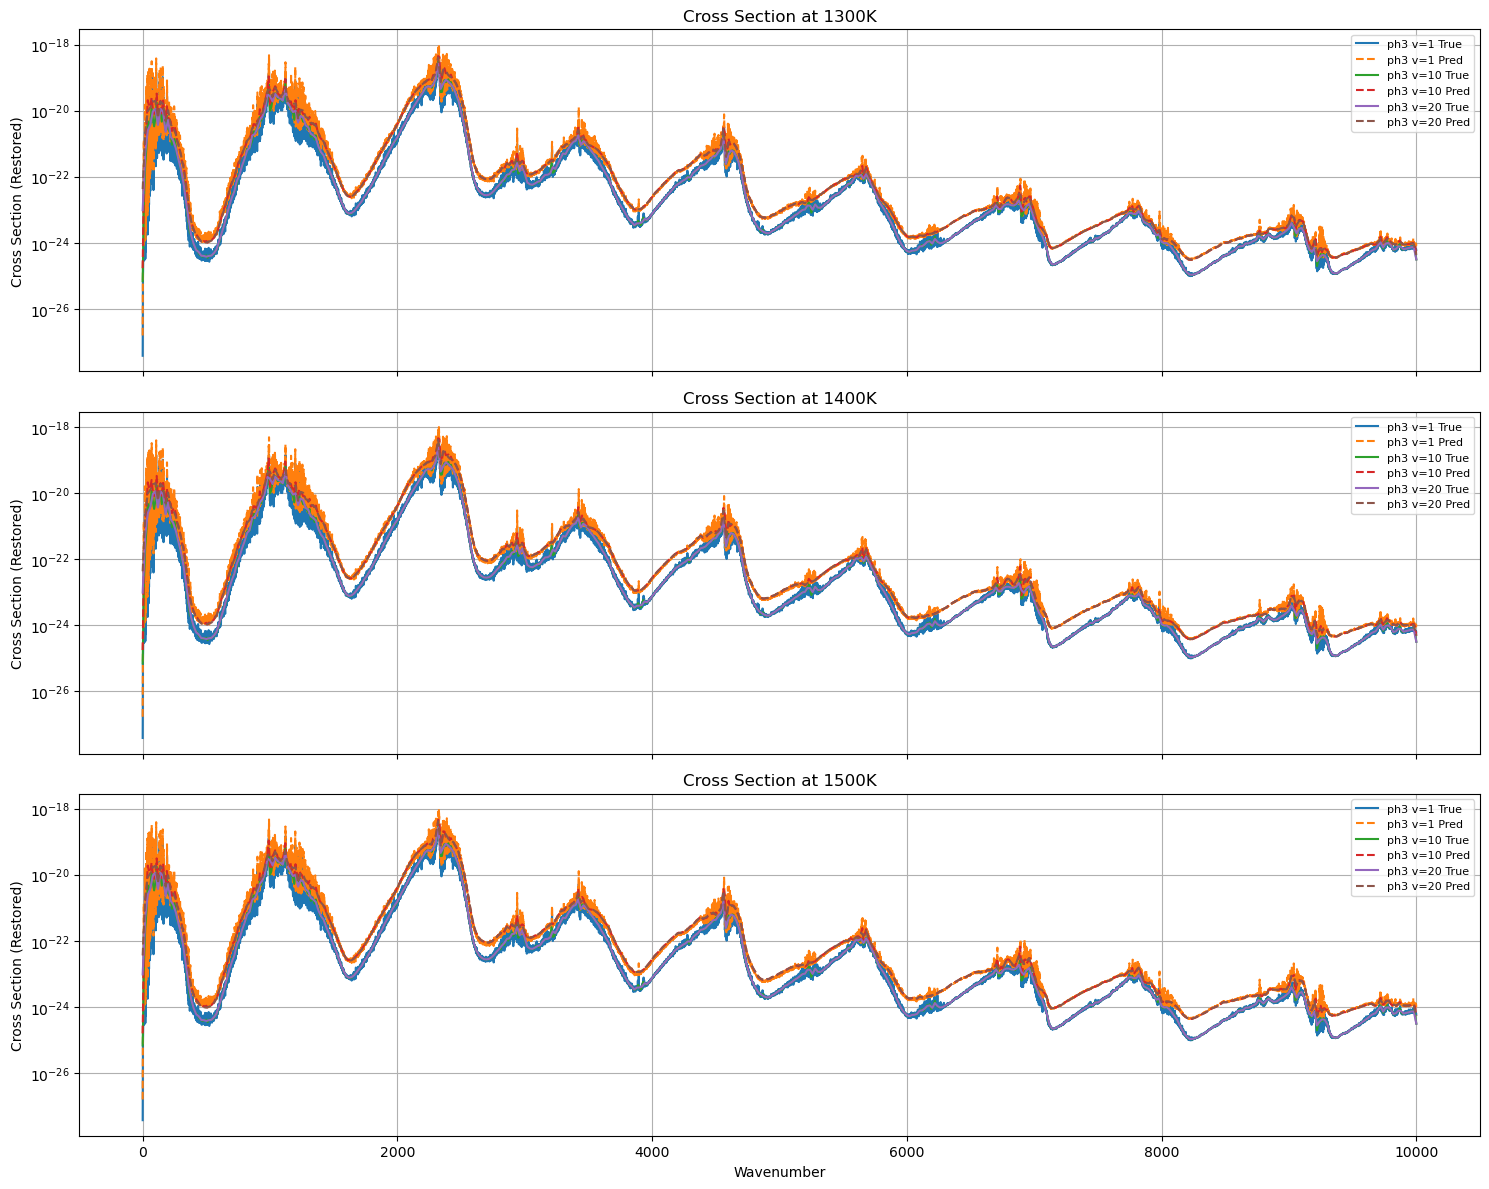

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== Data set path ==========
datasets = {
    'ph3 v=1': 'ph3_v=1.xlsm',
    'ph3 v=10': 'ph3_v=10.xlsm',
    'ph3 v=20': 'ph3_v=20.xlsm'
}

# ========== Defining function: normalisation + training + prediction + back-normalisation ==========
def process_dataset(name, file):
    # retrieve data
    df = pd.read_excel(file)
    df = df.rename(columns={'number': 'wavenumber'})
    
    # Divide training/testing (1300, 1400, 1500K for testing)
    columns_to_exclude = ['t=1300k', 't=1400k', 't=1500k']
    columns_to_normalize = [col for col in df.columns if col.startswith('t=') and col not in columns_to_exclude]

    # standardisation by bank
    data_to_normalize = df[columns_to_normalize].copy()
    row_means = data_to_normalize.mean(axis=1)
    row_stds = data_to_normalize.std(axis=1)
    df_scaled = (data_to_normalize.subtract(row_means, axis=0)).divide(row_stds, axis=0)

    # Save statistics
    df_stats = pd.DataFrame({
        'wavenumber': df['wavenumber'],
        'row_mean': row_means,
        'row_std': row_stds
    }).set_index('wavenumber')

    # Training data after splicing normalisation
    train_df = pd.concat([df[['wavenumber']], df_scaled], axis=1)

    # long chart
    long_df = pd.melt(
        train_df,
        id_vars='wavenumber',
        value_vars=[col for col in train_df.columns if col.startswith('t=')],
        var_name='temperature',
        value_name='cross_section'
    )
    long_df['temperature'] = long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    # Training/test set division
    test_df = df[['wavenumber'] + columns_to_exclude].rename(columns={'number': 'wavenumber'})
    test_long_df = pd.melt(
        test_df,
        id_vars='wavenumber',
        value_vars=columns_to_exclude,
        var_name='temperature',
        value_name='cross_section'
    )
    test_long_df['temperature'] = test_long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    X_train, y_train = long_df[['wavenumber', 'temperature']], long_df['cross_section']
    X_test, y_test = test_long_df[['wavenumber', 'temperature']], test_long_df['cross_section']

    # modelling
    model = make_pipeline(
        PolynomialFeatures(degree=6, include_bias=False),
        Lasso(alpha=1.0, max_iter=5000)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save predictions
    test_long_df['predicted'] = y_pred

    # inverse normalisation
    cross_section_restored = []
    predicted_restored = []
    for idx, row in test_long_df.iterrows():
        wnum = row['wavenumber']
        mean = df_stats.loc[wnum, 'row_mean']
        std = df_stats.loc[wnum, 'row_std']
        cs_restored = row['cross_section'] * std + mean
        pred_restored = row['predicted'] * std + mean
        cross_section_restored.append(cs_restored)
        predicted_restored.append(pred_restored)

    test_long_df['cross_section_restored'] = cross_section_restored
    test_long_df['predicted_restored'] = predicted_restored

    # Calculation of error indicators
    mse = mean_squared_error(test_long_df['cross_section'], test_long_df['predicted'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_long_df['cross_section'], test_long_df['predicted'])
    r2 = r2_score(test_long_df['cross_section'], test_long_df['predicted'])

    metrics = {'Dataset': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return test_long_df, metrics

# ========== Loop through all data sets ==========
results = {}
metrics_list = []
for name, file in datasets.items():
    df_result, metric = process_dataset(name, file)
    results[name] = df_result
    metrics_list.append(metric)

# Printing Error Indicator
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# ========== draw a comparison chart ==========
temps = [1300, 1400, 1500]
fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

for i, temp in enumerate(temps):
    ax = axs[i]
    for name, df in results.items():
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label=f'{name} True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label=f'{name} Pred')
    ax.set_title(f'Cross Section at {temp}K')
    ax.set_ylabel('Cross Section (Restored)')
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.set_yscale('log')

axs[-1].set_xlabel('Wavenumber')
plt.tight_layout()
plt.show()

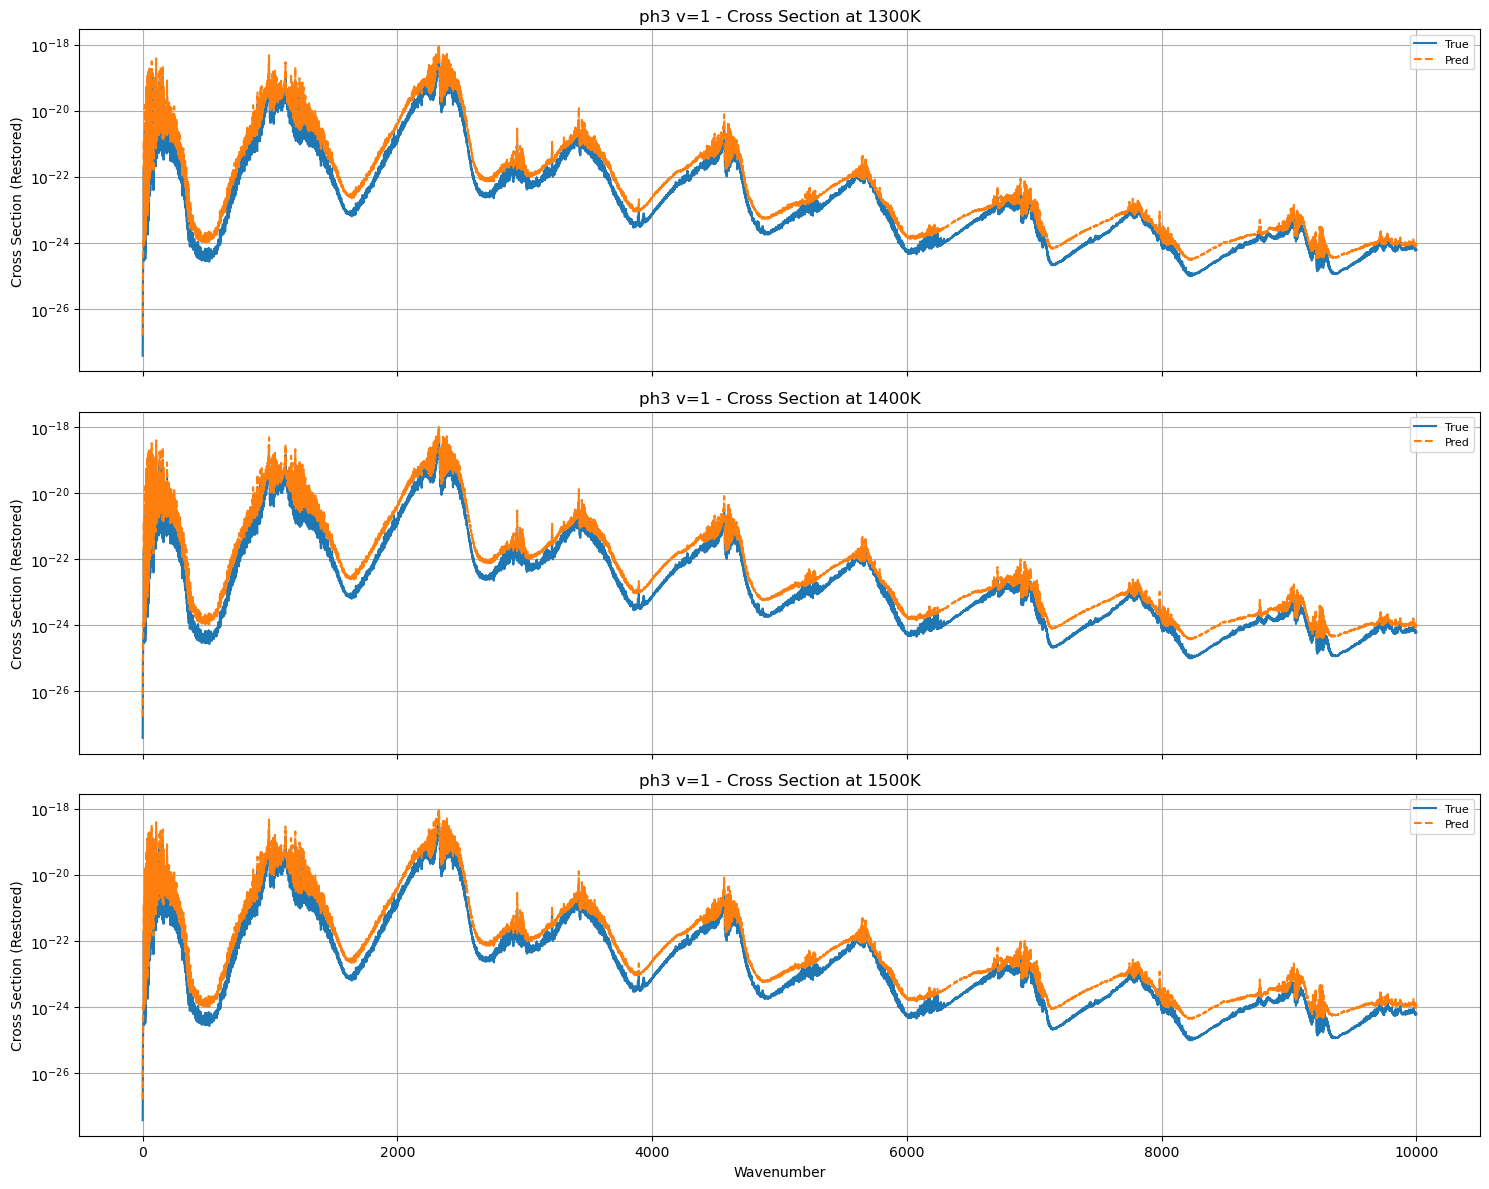

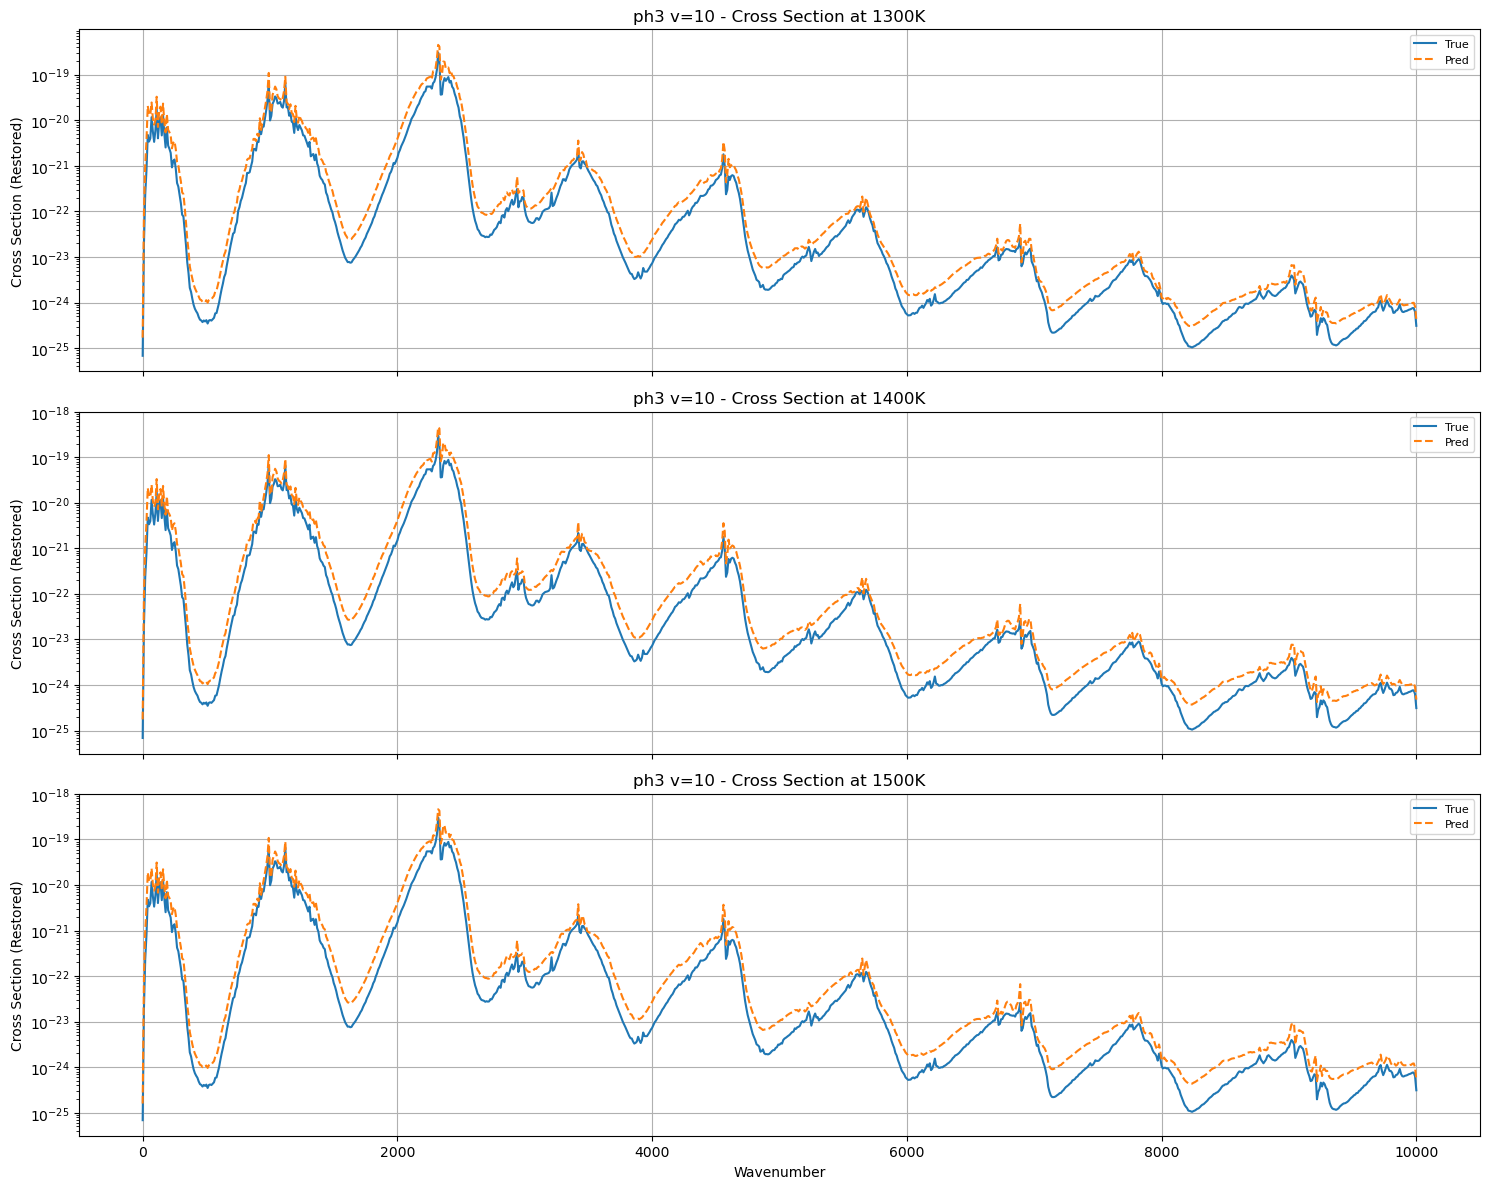

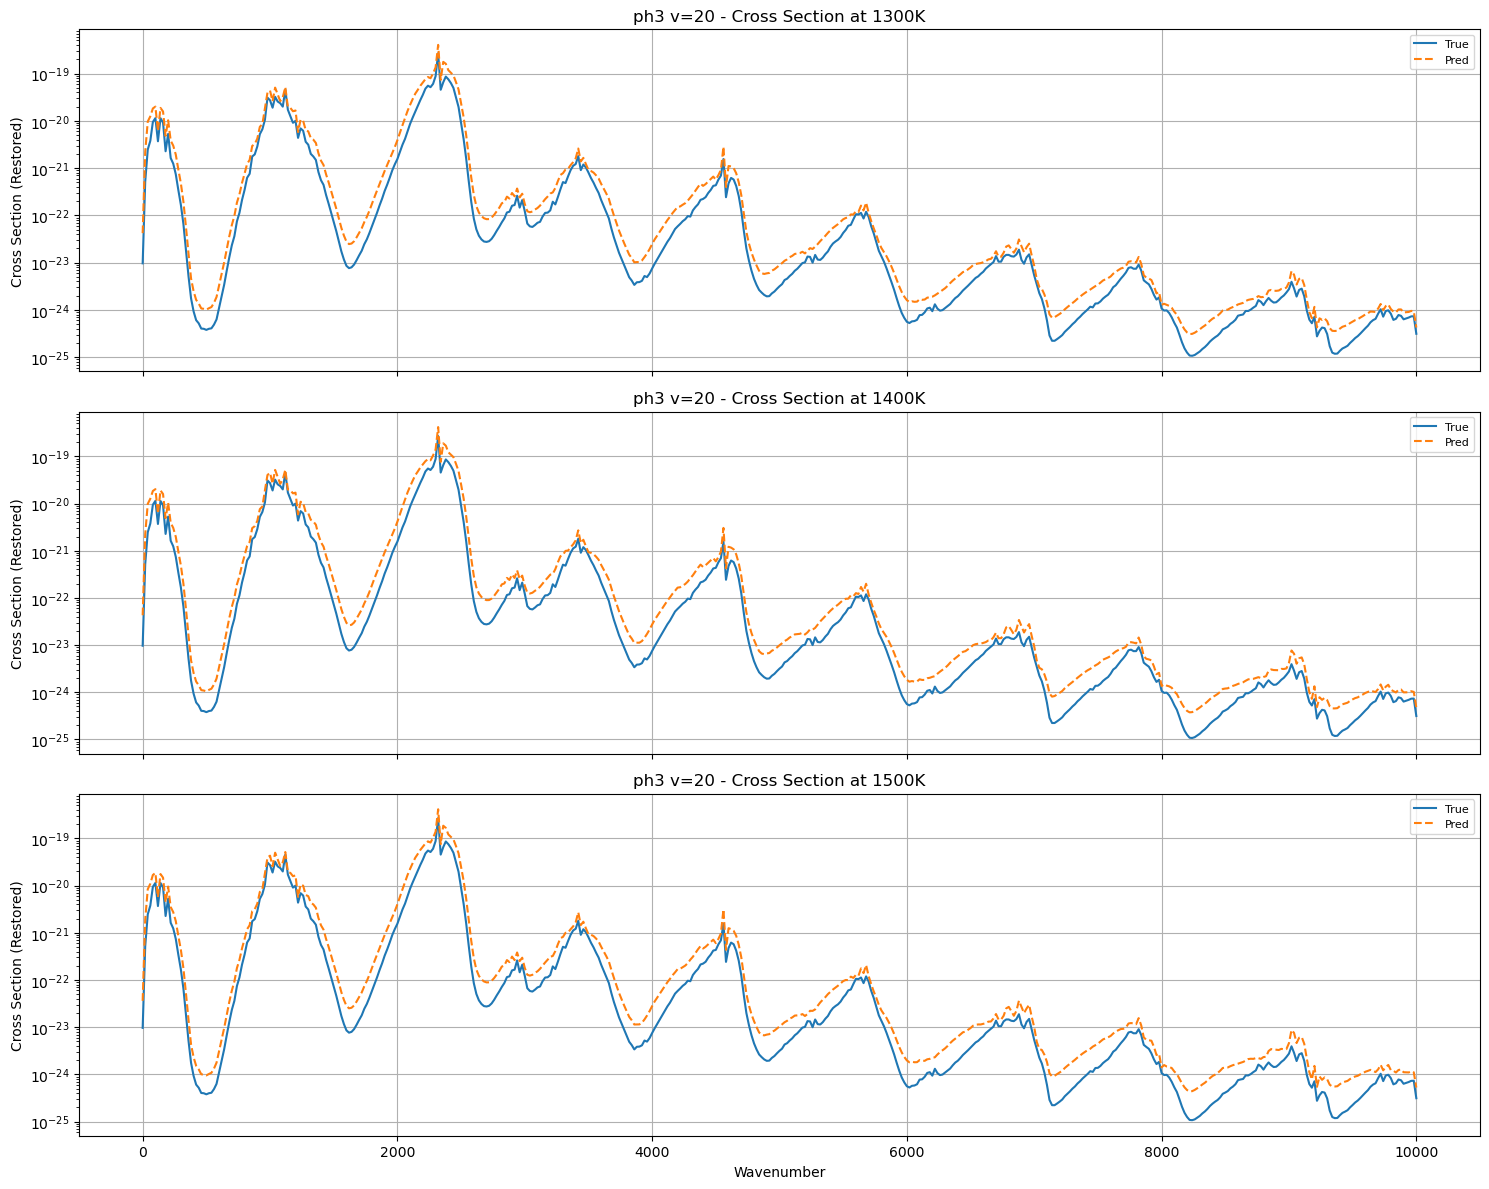

In [2]:
# ========== Draw a separate graph for each dataset ==========
temps = [1300, 1400, 1500]

for name, df in results.items():
    fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

    for i, temp in enumerate(temps):
        ax = axs[i]
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label='True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label='Pred')
        ax.set_title(f'{name} - Cross Section at {temp}K')
        ax.set_ylabel('Cross Section (Restored)')
        ax.legend(fontsize=8)
        ax.grid(True)
        ax.set_yscale('log')

    axs[-1].set_xlabel('Wavenumber')
    plt.tight_layout()
    plt.show()